In [1]:
from ay_torch import *

# Variational Auto Encoder test

Refs.

- https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
- https://github.com/hsinyilin19/ResNetVAE/blob/master/modules.py
- https://qiita.com/kenchin110100/items/7ceb5b8e8b21c551d69a
- https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24

In [2]:
'''
Reverse ResNet
Ref. https://github.com/PyTorchLightning/lightning-bolts/blob/master/pl_bolts/models/autoencoders/components.py
'''

class TInterpolate(torch.nn.Module):
  def __init__(self, size=None, scale_factor=None):
    super(TInterpolate,self).__init__()
    self.size,self.scale_factor= size,scale_factor
  def forward(self, x):
      return torch.nn.functional.interpolate(x, size=self.size, scale_factor=self.scale_factor)

def conv3x3(in_planes, out_planes, stride=1):
  """3x3 convolution with padding."""
  return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
  """1x1 convolution."""
  return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def resize_conv3x3(in_planes, out_planes, scale=1):
  """upsample + 3x3 convolution with padding to avoid checkerboard artifact."""
  if scale == 1:
    return conv3x3(in_planes, out_planes)
  return torch.nn.Sequential(TInterpolate(scale_factor=scale), conv3x3(in_planes, out_planes))

def resize_conv1x1(in_planes, out_planes, scale=1):
  """upsample + 1x1 convolution with padding to avoid checkerboard artifact."""
  if scale == 1:
    return conv1x1(in_planes, out_planes)
  return torch.nn.Sequential(TInterpolate(scale_factor=scale), conv1x1(in_planes, out_planes))


class DecoderBlock(torch.nn.Module):
  """ResNet block, but convs replaced with resize convs, and channel increase is in second conv, not first."""
  expansion = 1

  def __init__(self, inplanes, planes, scale=1, upsample=None):
    super().__init__()
    self.conv1 = resize_conv3x3(inplanes, inplanes)
    self.bn1 = torch.nn.BatchNorm2d(inplanes)
    self.relu = torch.nn.ReLU(inplace=True)
    self.conv2 = resize_conv3x3(inplanes, planes, scale)
    self.bn2 = torch.nn.BatchNorm2d(planes)
    self.upsample = upsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.upsample is not None:
        identity = self.upsample(x)

    out += identity
    out = self.relu(out)

    return out


class ResNetDecoder(torch.nn.Module):
  """Resnet in reverse order."""
  def __init__(self, block, layers, latent_dim, input_height, first_conv=False, maxpool1=False):
    super().__init__()

    self.expansion = block.expansion
    self.inplanes = 512 * block.expansion
    self.first_conv = first_conv
    self.maxpool1 = maxpool1
    self.input_height = input_height

    self.upscale_factor = 8

    self.linear = torch.nn.Linear(latent_dim, self.inplanes * 4 * 4)

    self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
    self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
    self.layer3 = self._make_layer(block, 64, layers[2], scale=2)

    if self.maxpool1:
        self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
        self.upscale_factor *= 2
    else:
        self.layer4 = self._make_layer(block, 64, layers[3])

    if self.first_conv:
        self.upscale = TInterpolate(scale_factor=2)
        self.upscale_factor *= 2
    else:
        self.upscale = TInterpolate(scale_factor=1)

    # interpolate after linear layer using scale factor
    self.upscale1 = TInterpolate(size=input_height // self.upscale_factor)

    self.conv1 = torch.nn.Conv2d(64 * block.expansion, 3, kernel_size=3, stride=1, padding=1, bias=False)

  def _make_layer(self, block, planes, blocks, scale=1):
    upsample = None
    if scale != 1 or self.inplanes != planes * block.expansion:
        upsample = torch.nn.Sequential(
            resize_conv1x1(self.inplanes, planes * block.expansion, scale),
            torch.nn.BatchNorm2d(planes * block.expansion),
        )

    layers = []
    layers.append(block(self.inplanes, planes, scale, upsample))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes))

    return torch.nn.Sequential(*layers)

  def forward(self, x):
    x = self.linear(x)

    # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
    # x = F.interpolate(x, scale_factor=4)

    x = x.view(x.size(0), 512 * self.expansion, 4, 4)
    x = self.upscale1(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.upscale(x)

    x = self.conv1(x)
    return x

def resnet18_decoder(latent_dim, input_height, first_conv, maxpool1):
  return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)

In [3]:
decoder = resnet18_decoder(
            latent_dim=8,
            input_height=24,
            first_conv=False,
            maxpool1=False)
decoder
# decoder(torch.zeros(1,8)).shape
# torchinfo.summary(decoder, input_size=torch.zeros(1,8).shape)

ResNetDecoder(
  (linear): Linear(in_features=8, out_features=8192, bias=True)
  (layer1): Sequential(
    (0): DecoderBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Sequential(
        (0): TInterpolate()
        (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (upsample): Sequential(
        (0): Sequential(
          (0): TInterpolate()
          (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): DecoderBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [4]:
class TResNetVAE(torch.nn.Module):
  def __init__(self, in_imgshape, encoder_args=None, latent_dim=256, n_hiddens=1, hidden_channels=768, p_dropout=0.0):
    super(TResNetVAE,self).__init__()
    default_encoder_args= {'expansion':1}
    encoder_args= MergeDict(default_encoder_args,encoder_args) if encoder_args else default_encoder_args
    self.encoder= TResNet(TResBlock, **encoder_args, layers=[2, 2, 2, 2], in_channels=in_imgshape[0], with_fc=False)
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    self.fc_base= torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Linear(ndim_encoder, hidden_channels),
          torch.nn.ReLU(),
          torch.nn.Dropout(p_dropout),
          *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens)],
          torch.nn.Dropout(p_dropout),
          )
    self.fc_mu= torch.nn.Linear(hidden_channels, latent_dim)
    self.fc_logvar= torch.nn.Linear(hidden_channels, latent_dim)
    
    self.decoder= resnet18_decoder(
            latent_dim=latent_dim,
            input_height=in_imgshape[-1],
            first_conv=False,
            maxpool1=False)

  def forward(self, x):
    x_encoded= self.encoder(x)
    h= self.fc_base(x_encoded)
    mu, log_var= self.fc_mu(h), self.fc_logvar(h)
    std= torch.exp(log_var/2.)
    if self.training:
      q= torch.distributions.Normal(mu, std)
      z= q.rsample()
    else:
      z= mu
    x_reconstructed= self.decoder(z)
    return x_reconstructed, z, mu, std

class TVAELoss(torch.nn.Module):
  def __init__(self):
    super(TVAELoss,self).__init__()
    self.log_scale= torch.nn.Parameter(torch.Tensor([0.0]))
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    x_reconstructed,z,mu,std= y_pred
    x= y_trg
    self.log_scale.to(x.device)
    dstr= torch.distributions.Normal(x_reconstructed, torch.exp(self.log_scale.to(x.device)))
    reconst_loss= dstr.log_prob(x).sum(dim=(1, 2, 3))
    p= torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q= torch.distributions.Normal(mu, std)
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)
    kld= (log_qzx-log_pz).sum(-1)
    elbo= (kld-reconst_loss).mean()
    return elbo

# VAE for CIFAR-10

In [5]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(64),
        torchvision.transforms.Pad(10, padding_mode='constant'),  #'reflect'
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        torchvision.transforms.CenterCrop(64),
        torchvision.transforms.RandomResizedCrop(32, scale=(0.75,1.), ratio=(1.,1.)),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.ToTensor()
      ])

In [6]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


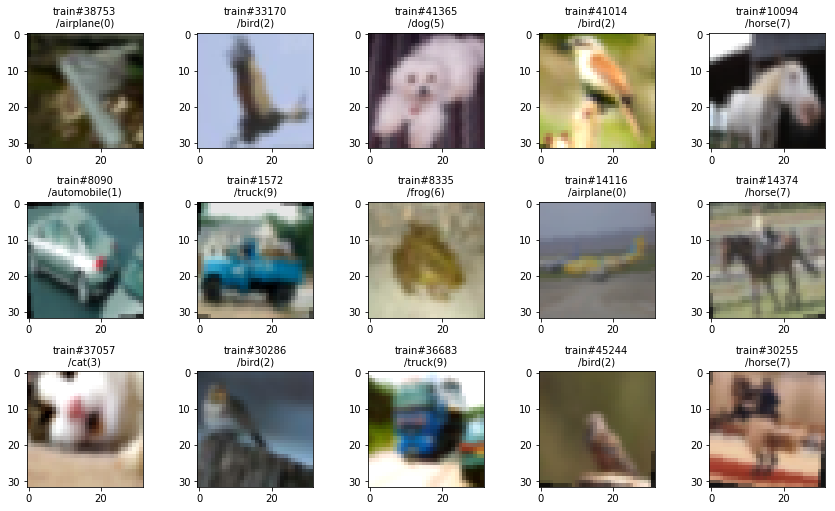

In [7]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [8]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetVAE(in_imgshape=in_imgshape)

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TVAELoss()
f_metric= None

def tfm_batch(batch):
  x,y= batch
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
net
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 3, 32, 32)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetVAE                                         --                        --
├─TResNet: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 32, 32, 32]           864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 32, 32]           64
│    │    └─ReLU: 3-3                              [1, 32, 32, 32]           --
│    └─Sequential: 2-2                             [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-4                            [1, 32, 16, 16]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 16, 16]           64
│    │    └─ReLU: 3-6                              [1, 32, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%


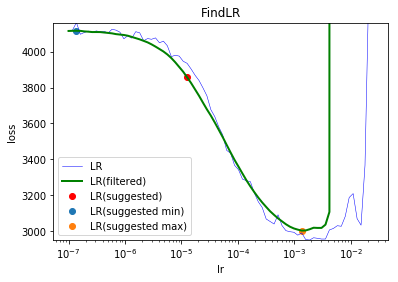

lr= 1.258925411794167e-05, lr_min=1.3803842646028847e-07, lr_max=0.0013489628825916527


In [10]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	3075.65349202	2926.14598832	nan	54.552337
1	2891.91417271	2889.63594901	nan	54.664189
2	2881.40387103	2884.58404658	nan	54.855742
3	2877.25070588	2881.99497412	nan	55.081004
4	2874.97445796	2881.92848546	nan	55.142619
5	2873.06629542	2880.20166793	nan	55.014526
6	2871.70915015	2877.11043864	nan	55.016928
7	2870.45339693	2876.52354946	nan	55.146137
8	2869.57803009	2875.56307847	nan	55.055379
9	2868.82544445	2875.28045538	nan	55.217122


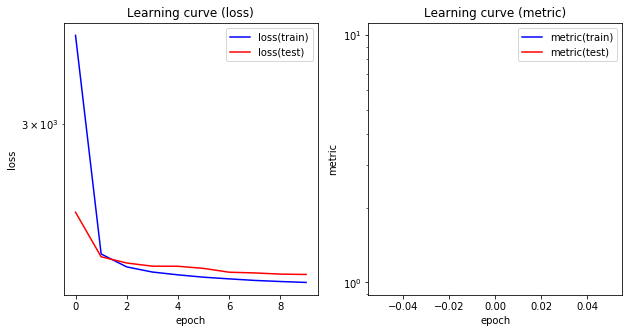

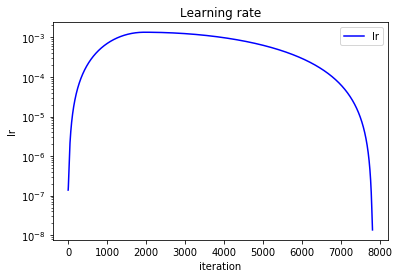

In [11]:
# lr_min,lr_max= 1.e-4, 3.e-3
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

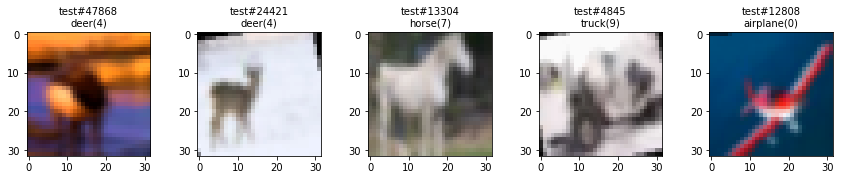

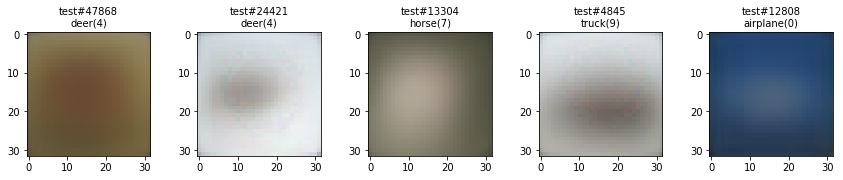

In [17]:
d= dset_train
# d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
plabels= [f'pred#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels, rows=1)
PlotImgGrid(pred, labels, rows=1)

# VAE for MNIST

In [10]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.ToTensor()
      ])

In [11]:
dset_train= torchvision.datasets.MNIST(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.MNIST(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

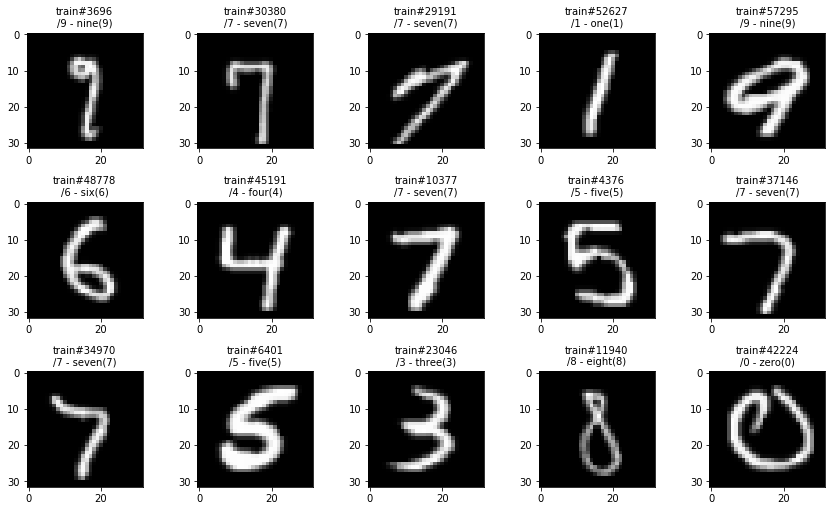

In [12]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [18]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetVAE(in_imgshape=in_imgshape)

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TVAELoss()
f_metric= None

def tfm_batch(batch):
  x,y= batch
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

In [19]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
net
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 1, 32, 32)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetVAE                                         --                        --
├─TResNet: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 32, 32, 32]           288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 32, 32]           64
│    │    └─ReLU: 3-3                              [1, 32, 32, 32]           --
│    └─Sequential: 2-2                             [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-4                            [1, 32, 16, 16]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 16, 16]           64
│    │    └─ReLU: 3-6                              [1, 32, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%


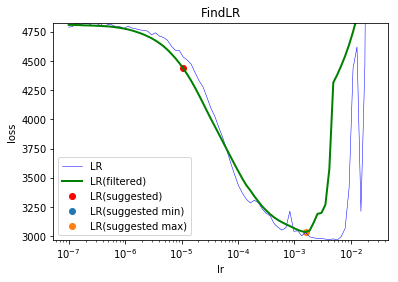

lr= 1.071519305237606e-05, lr_min=0.024547089156850308, lr_max=0.001584893192461113


In [15]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	2920.63243640	2893.15483336	nan	65.568011
1	2886.17681638	2876.38273941	nan	66.067056
2	2873.53153292	2867.02878371	nan	65.685375
3	2867.79675345	2865.59308444	nan	66.205379
4	2864.41638886	2862.70590229	nan	65.095388
5	2862.36827182	2860.54154900	nan	65.140261
6	2860.20471478	2858.42815423	nan	64.985626
7	2858.27632736	2856.53906094	nan	65.161684
8	2856.59608938	2855.39576595	nan	65.044875
9	2855.53101159	2854.99929557	nan	65.006249


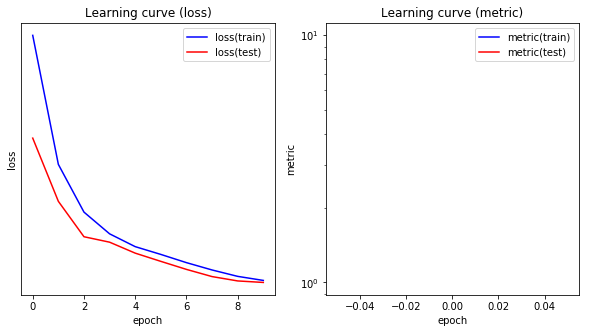

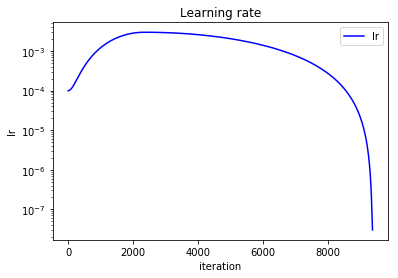

In [20]:
# lr_min,lr_max= 1.e-4, 3.e-3
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

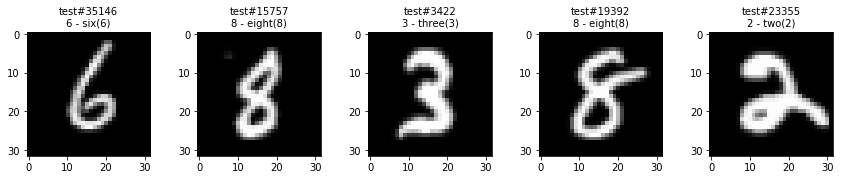

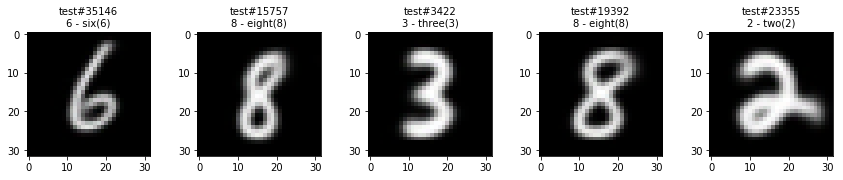

In [34]:
d= dset_train
# d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
plabels= [f'pred#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels, rows=1)
PlotImgGrid(pred, labels, rows=1)